In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt



In [10]:
# Load and pre-process data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess input for ResNet50
x_train = tf.keras.applications.resnet50.preprocess_input(x_train)
x_test = tf.keras.applications.resnet50.preprocess_input(x_test)

# Convert labels to categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Train data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


Train data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [11]:
# Load the ResNet50 model
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Freeze all layers except the last few
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Create the model
model = Sequential([
    layers.Lambda(lambda image: tf.image.resize(image, (224, 224))),
    base_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(10, activation="softmax"),
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [12]:
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.00002), loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks
lr_schedule = ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, patience=1, min_lr=1e-6, verbose=1
)

es = EarlyStopping(
    monitor="val_accuracy", mode="max", patience=2, restore_best_weights=True
)


In [13]:
# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    callbacks=[es, lr_schedule],
    validation_split=0.2,
    verbose=1,
)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 170s 119ms/step - accuracy: 0.2558 - loss: 2.2500 - val_accuracy: 0.8293 - val_loss: 0.8041 - learning_rate: 2.0000e-05
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 199s 125ms/step - accuracy: 0.5284 - loss: 1.4087 - val_accuracy: 0.8712 - val_loss: 0.6095 - learning_rate: 2.0000e-05
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 201s 124ms/step - accuracy: 0.6476 - loss: 1.1165 - val_accuracy: 0.8936 - val_loss: 0.4917 - learning_rate: 2.0000e-05
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 201s 124ms/step - accuracy: 0.7207 - loss: 0.9432 - val_accuracy: 0.9102 - val_loss: 0.4135 - learning_rate: 2.0000e-05
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 202s 124ms/step - accuracy: 0.7765 - loss: 0.7966 - val_accuracy: 0.9157 - val_loss: 0.3566 - learning_rate: 2.0000e-05
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 202s 124ms/step - accuracy: 0.8179 - loss: 0.6883 - val_accuracy: 0.9228 - val_loss: 0.3151 - learning_rate: 2.0000e-05
Epoch 7/10
1250/1250 ━━━━━━━

In [14]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")




Final Test Accuracy: 0.9296


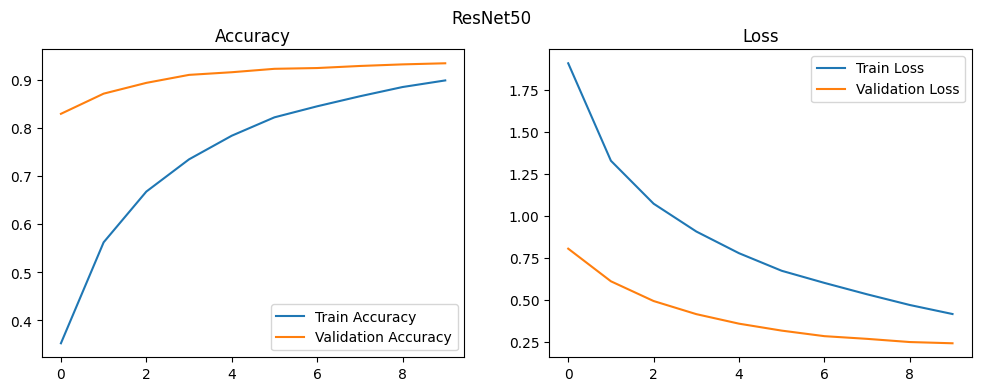

In [15]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_history(history, "ResNet50")


##CIFAR-10 Classification: Custom CNN vs ResNet50 (Transfer Learning)
Dataset: CIFAR-10
60,000 images, 10 classes
Input shape: (32, 32, 3)

##Model 1: Custom CNN from Scratch
Built using multiple Conv2D, MaxPooling2D, Dropout, and Dense layers

Trained entirely on CIFAR-10 without any pre-trained weights

Achieved 79.64% accuracy on the test set

Lightweight model with interpretable architecture

Pros: Simple design, less memory required

Cons: Lower accuracy, longer training time to converge

##Model 2: ResNet50 (Transfer Learning)
Pretrained on ImageNet (include_top=False)

Custom classification head added (GlobalAveragePooling, Dense, Dropout, Softmax)

Froze initial 75 layers out of 175

Fine-tuned remaining 100 layers on CIFAR-10

Used learning rate scheduler, early stopping, and dropout for regularization

Achieved 92.96% accuracy on the test set

Pros: High accuracy, faster convergence due to pretrained features

Cons: Heavier model, higher memory and computational cost

##Summary Table

| Model         | Accuracy | Frozen Layers | Total Layers | Pretrained | Notes                  |
| ------------- | -------- | ------------- | ------------ | ---------- | ---------------------- |
| Custom CNN    | 79.64%   | 0             | Custom       | No         | Trained from scratch   |
| ResNet50 (FT) | 92.96%   | 75            | 175          | Yes        | Used transfer learning |


#Key Takeaways / Learnings
Transfer learning with ResNet50 gave a significant accuracy improvement.

Freezing lower layers helps retain general features and speeds up training.

Even basic CNNs can work well with good tuning, but transfer learning gives a performance edge.

ResNet50 took more memory and training adjustments (e.g., single-phase fine-tuning worked better).

